### This file is used to learnig the solution operator for the boundary integral equations (from g to h) for PDEs:
$$ \begin{cases}
u - \tau \Delta u = 0, & x \in \Omega, \\
u = g, & x \in \partial \Omega,
\end{cases} $$
where $\Omega = [0, 1]^2$ and parameter $\tau \in [0.05, 0.1]$.

Note that it is equivalent to solve $\frac{1}{\tau} u - \Delta u = 0$.

#### Given a fixed $g$, the solution of this PDE can be written as
$$ u(x) = \int_{\partial \Omega} \frac{\partial G_0(x,y)}{\partial n_y} h(y) d s_y,\quad x \in \Omega, $$
where the density function $h$ is the solution of this boundary integral equation:
$$ \int_{\partial \Omega} \frac{\partial G_0(x_0,y)}{\partial n_y} h(y) d s_y + \frac{1}{2} h(x_0) = g(x_0),\quad x_0 \in \partial \Omega, $$
with the fundamental solution (of $\frac{1}{\tau} id - \Delta$):
$$G_0(x, y) = -\frac{1}{2 \pi} \mathbb{K}_0(\frac{|x - y|}{\sqrt{\tau}}), $$
here $\mathbb{K}_{\gamma}(x)$ is the modified Bessel function of the second kind of order $\gamma$.

Remark that $$\mathbb{K}_{0}(x) \approx - \ln(\frac{x}{2}) - \gamma_E + (1 - \gamma_E)\frac{x^2}{4}$$ and $$\mathbb{K}'_{0}(x) \approx - \frac{1}{x} + (1-\gamma_E)\frac{x}{2}$$ near $x = 0.$

Suppose that the domain boundary $\partial \Omega$ has a parametric representation: $\textbf{x} = x(t) = (x_1(t), x_2(t))\ \text{for}\ t \in [0, 4)$. The boundary integral equation above now reads:
$$
\frac{1}{2} h(t)+\frac{1}{2 \pi} \int_0^{4} \frac{\partial (-\mathbb{K}_0(\frac{|\textbf{x}(t) - \textbf{x}(s)|)}{\sqrt{\tau}})}{\partial \mathbf{n}_s} h(s)\left|\mathbf{x}^{\prime}(s)\right| d s=g(t) \quad \text { for } t \in[0, 4)
$$
or
$$
\frac{1}{2} h(t)+\frac{1}{2 \pi} \int_0^{4} k(t, s) h(s) d s=g(t) \quad \text { for } t \in[0, 4)
$$
with kernel
$$
k(t, s)=\left\{\begin{array}{ll}
- \mathbb{K}'_0(\frac{|\textbf{x}(t) - \textbf{x}(s)|}{\sqrt{\tau}}) \frac{x'_2(s) (x_1(s) - x_1(t)) - x'_1(s) (x_2(s) - x_2(t))}{\sqrt{\tau [(x_1(t
) - x_1(s))^2 + (x_2(t) - x_2(s))^2]}} & \text { if } s \neq t \\
\frac{1}{2} \frac{x''_2(t) x'_1(t) - x''_1(t) x'_2(t)}{x'_1(t)^2 + x'_2(t)^2} & \text { if } s=t
\end{array} .\right.
$$

#### Thus we can construct a network $\mathcal{NN}$ with parameters $\Theta$ from $g$ to $h$ which can be regarded as the solution of the corresponding boundary integral equation. We just need to sample functions $g$ from the proper space to get a dataset $\{g_i\}_{i=1}^{M}$, and the $\text{Loss}$ funciton can be setted as:
$$\text{Loss}(\Theta) = \frac{1}{M_{\text{train}}} \sum_{i = 1}^{M_{\text{train}}} \sum_{j = 1}^N \{[\int_{\partial \Omega} \frac{\partial G_0(x_j,y)}{\partial n_y} \mathcal{NN}(\Theta; y) d s_y + \frac{1}{2} \mathcal{NN}(\Theta; x_j)] - g_i(x_j)\}^2,$$
where $\{x_j\}_{j=1}^N$ are sample points on the boundary $\partial \Omega$.

In [27]:
import time
import os
import torch
import numpy as np
from torch import nn
from matplotlib import pyplot as plt

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    gpu_info = torch.cuda.get_device_properties(0)
    print(f"GPU: {gpu_info.name}")
    print(f"GPU memory: {gpu_info.total_memory / 1024**2:.2f} MB")

GPU: NVIDIA GeForce RTX 3080
GPU memory: 10006.69 MB


In [29]:
class MLP(torch.nn.Module):
    def __init__(self, n_input, n_hidden, n_output, n_layers):
        super(MLP, self).__init__()
        self.act = nn.ReLU()
        self.layin = torch.nn.Linear(n_input, n_hidden)
        self.hidden_layers = torch.nn.ModuleList([torch.nn.Linear(n_hidden, n_hidden) for _ in range(n_layers)])
        self.layout = torch.nn.Linear(n_hidden, n_output)
    def forward(self, g):
       g = self.layin(g)
       g = self.act(g)
       for layer in self.hidden_layers:
           g = layer(g)
           g = self.act(g)
       h = self.layout(g)
       return h
    
class DeepONet(torch.nn.Module):
    def __init__(self, n_g, n_h, n_hidden, n_layers):
        super(DeepONet, self).__init__()
        self.for_tau = MLP(1, n_g, n_hidden, n_layers)
        self.for_g_1 = torch.nn.Linear(n_g, n_hidden)
        self.for_g_2 = torch.nn.Linear(n_hidden, n_h)
    def forward(self, tau, g):      #  tau: scalar, g: (batch_size, n_g)
       tau = tau + torch.zeros_like(g[:, 1].view(-1, 1))
       tau = self.for_tau(tau)
       g = self.for_g_1(g)
       h = self.for_g_2(tau * g)
       return h

In [30]:
def generate_square_points(n, plot):
    # Boundary points per side without including corners
    boundary_spacing = np.linspace(1 / (2 * n), 1 - 1 / (2 * n), n)
    
    # Bottom boundary (x varies, y is 0)
    bottom_boundary = np.column_stack((boundary_spacing, np.zeros(n)))
    # Right boundary (x is 1, y varies)
    right_boundary = np.column_stack((np.ones(n), boundary_spacing))
    # Top boundary (x varies, y is 1)
    top_boundary = np.column_stack((boundary_spacing[::-1], np.ones(n)))
    # Left boundary (x is 0, y varies)
    left_boundary = np.column_stack((np.zeros(n), boundary_spacing[::-1]))
    
    # Combine boundary points in sequence
    boundary_points = np.vstack([bottom_boundary, right_boundary, top_boundary, left_boundary])

    t_boundary = np.zeros((len(boundary_points), 1)) 
    for i in range(len(boundary_points)):
        if(boundary_points[i,1] == 0):
            t_boundary[i] = boundary_points[i,0]
        elif(boundary_points[i,0] == 1):
            t_boundary[i] = 1 + boundary_points[i,1]
        elif(boundary_points[i,1] == 1):
            t_boundary[i] = 3 - boundary_points[i,0]
        else:
            t_boundary[i] = 4 - boundary_points[i,1]

    # Generate interior points if n > 2 (excluding boundary)
    if n > 2:
        x_interior = np.linspace(0.05, 0.95, n // 8)
        y_interior = np.linspace(0.05, 0.95, n // 8)
        xx_interior, yy_interior = np.meshgrid(x_interior, y_interior)
        interior_points = np.vstack([xx_interior.ravel(), yy_interior.ravel()]).T
    else:
        interior_points = np.empty((0, 2))  # No interior points if n <= 2

    # Plotting
    if plot:
        plt.figure(figsize=(6, 6))
        plt.scatter(interior_points[:, 0], interior_points[:, 1], color='blue', label='Interior Points', s=10)
        plt.scatter(boundary_points[:, 0], boundary_points[:, 1], color='red', label='Boundary Points', s=1)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.title("Square Grid Points")
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()
    
    return 1 / n, t_boundary, boundary_points, interior_points

In [31]:
taus = [0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1]
N = 128

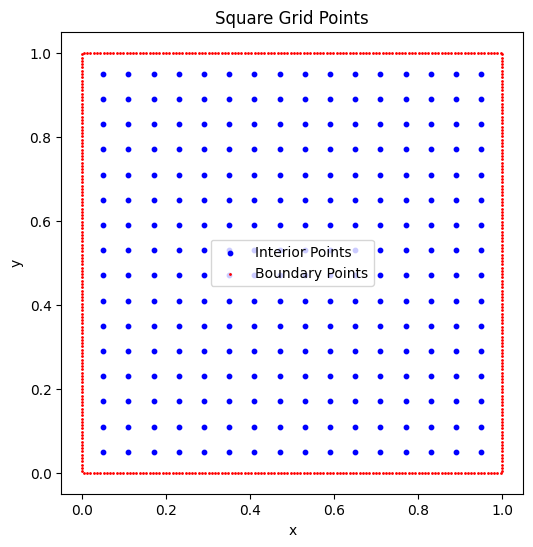

In [32]:
h, s_for_integral, x_bd, x_interior = generate_square_points(N, True)
s_for_intergal_pt = torch.from_numpy(s_for_integral).clone().float().to(device).view(-1, 1)
x_bd_pt = torch.from_numpy(x_bd).clone().float().to(device)
x_interior_pt = torch.from_numpy(x_interior).clone().float().to(device)

In [33]:
from scipy.special import kv, kvp

def kernel_bd(tau, t, s):
    if s < 1:
        x1_s, x2_s, x1_prime_s, x2_prime_s = s, 0, 1, 0
    elif s < 2:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 1, s - 1, 0, 1
    elif s < 3:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 3 - s, 1, - 1, 0
    else:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 0, 4 - s, 0, -1
    
    if t < 1:
        x1_t, x2_t = t, 0
    elif t < 2:
        x1_t, x2_t = 1, t - 1
    elif t < 3:
        x1_t, x2_t = 3 - t, 1
    else:
        x1_t, x2_t = 0, 4 - t

    if (s != t):
        r = np.sqrt((x1_s - x1_t) ** 2 + (x2_s - x2_t) ** 2)
        result = - kvp(0, r / np.sqrt(tau), n=1) * (x2_prime_s * (x1_s - x1_t) - x1_prime_s * (x2_s - x2_t)) / (np.sqrt(tau) * r)
        return result
    else:
        return 0.
    
kernels_for_bd = torch.zeros(len(taus), len(x_bd), len(x_bd))
for k in range(len(taus)):
    for i in range(len(x_bd)):
        for j in range(len(x_bd)):
            kernels_for_bd[k, i, j] = h * kernel_bd(taus[k], s_for_integral[i, 0], s_for_integral[j, 0])

In [34]:
def predict_u_bd(net, tau, g):      # tau: scalar, g: (batch_size, n_g)
    flag = 0
    for i in range(len(taus)):
        if np.abs(tau - taus[i]) < 1e-6:
            kernel = kernels_for_bd[i, :, :]
            flag = 1
            # print(taus[i])
            
    if flag == 0 and tau > 0:
        kernel = torch.zeros(len(x_bd), len(x_bd))
        for i in range(len(x_bd)):
            for j in range(len(x_bd)):
                kernel[i, j] = h * kernel_bd(tau, s_for_integral[i, 0], s_for_integral[j, 0])
    else:
        exit("The value of tau is illegal!")

    kernel = kernel.to(device)
    result = 0.5 * net(tau, g).T + 0.5 / (np.pi) * kernel @ net(tau, g).T 
    return result.T

In [35]:
def kernel_int(tau, x, s):
    x1, x2 = x[0], x[1]
    if s < 1:
        x1_s, x2_s, x1_prime_s, x2_prime_s = s, 0, 1, 0
    elif s < 2:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 1, s - 1, 0, 1
    elif s < 3:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 3 - s, 1, - 1, 0
    else:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 0, 4 - s, 0, -1
    r = np.sqrt((x1_s - x1) ** 2 + (x2_s - x2) ** 2)
    result = - kvp(0, r / np.sqrt(tau), n=1) * (x2_prime_s * (x1_s - x1) - x1_prime_s * (x2_s - x2)) / (np.sqrt(tau) * r)
    return result

kernels_for_int = torch.zeros(len(taus), len(x_interior), len(x_bd))
for k in range(len(taus)):
    for i in range(len(x_interior)):
        for j in range(len(x_bd)):
            kernels_for_int[k, i, j] = h * kernel_int(taus[k], x_interior[i, :], s_for_integral[j, 0])

In [36]:
def predict_u_int(net, tau, g):      # tau: scalar, g: (batch_size, n_g)
    flag = 0
    for i in range(len(taus)):
        if np.abs(tau - taus[i]) < 1e-6:
            kernel = kernels_for_int[i, :, :]
            flag = 1
            # print(taus[i])
    
    if flag == 0 and tau > 0:
        kernel = torch.zeros(len(x_interior), len(x_bd))
        for i in range(len(x_interior)):
            for j in range(len(x_bd)):
                kernel[i, j] = h * kernel_int(tau, x_interior[i, :], s_for_integral[j, 0])
    else:
        exit("The value of tau is illegal!")

    kernel = kernel.to(device)

    result = 0.5 / (np.pi) * kernel @ net(tau, g).T
    return result.T

In [37]:
from scipy.ndimage import gaussian_filter

def generate_exact_solution_1(num_samples, n, sigma):
    g_list = []
    for _ in range(num_samples):
        g = np.random.randn(n)
        g = gaussian_filter(g, sigma=sigma)
        g_list.append(g)
    return g_list

def generate_exact_solution_2(num_samples):
    g_list = []
    x = x_bd[:, 0].reshape(-1)
    y = x_bd[:, 1].reshape(-1)

    for _ in range(num_samples // 4):
        a = np.random.uniform(0.5, 4.5)
        b = np.random.uniform(0.5, 4.5)
        c = np.random.uniform(0.5, 4.5)
        g = a * np.sin(b * np.pi * x) * np.sin(c * np.pi * y)
        g_list.append(g)

    for _ in range(num_samples // 4):
        a = np.random.uniform(0.5, 4.5)
        b = np.random.uniform(0.5, 4.5)
        c = np.random.uniform(0.5, 4.5)
        g = a * np.cos(b * np.pi * x) * np.cos(c * np.pi * y)
        g_list.append(g)

    for _ in range(num_samples // 4):
        a = np.random.uniform(0.5, 4.5)
        b = np.random.uniform(0.5, 4.5)
        c = np.random.uniform(0.5, 4.5)
        g = a * np.sin(b * np.pi * x) * np.cos(c * np.pi * y)
        g_list.append(g)

    for _ in range(num_samples - num_samples // 4 - num_samples // 4 - num_samples // 4):
        a = np.random.uniform(0.5, 4.5)
        b = np.random.uniform(0.5, 4.5)
        c = np.random.uniform(0.5, 4.5)
        g = a * np.cos(b * np.pi * x) * np.sin(c * np.pi * y)
        g_list.append(g)

    return g_list

def generate_g(num_of_samples):

    g_1 = generate_exact_solution_1(num_of_samples // 10, 4 * N, 1)
    g_2 = generate_exact_solution_1(num_of_samples // 10, 4 * N, 2)
    g_3 = generate_exact_solution_1(num_of_samples // 10, 4 * N, 3)
    g_4 = generate_exact_solution_1(num_of_samples // 10, 4 * N, 4)
    g_5 = generate_exact_solution_1(num_of_samples // 10, 4 * N, 5)
    g_6 = generate_exact_solution_2(num_of_samples - 5 * (num_of_samples // 10))
    
    g_list = g_1 + g_2 + g_3 + g_4 + g_5 + g_6
        
    return np.array(g_list)

In [38]:
g_np = generate_g(10000)

In [39]:
np.linalg.matrix_rank(g_np, tol=1e-6)

512

In [40]:
from torch.utils.data import TensorDataset, DataLoader, random_split

g_pt = torch.tensor(g_np, dtype=torch.float32).to(device)
dataset = TensorDataset(g_pt)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_g = torch.stack([train_dataset[i][0] for i in range(len(train_dataset))])
test_g = torch.stack([test_dataset[i][0] for i in range(len(test_dataset))])

In [41]:
def U(tau, x):
    x1 = x[:, 0].view(-1, 1)
    x2 = x[:, 1].view(-1, 1)
    return torch.exp(-np.sqrt(1 + 1 / tau) * x1) * torch.sin(x2)
    # return torch.exp(np.sqrt(1 / tau) * x1) + torch.exp(np.sqrt(1 / tau) * x2)

In [42]:
net = DeepONet(N * 4, N * 4, N * 3, 2).to(device)
criterion = nn.MSELoss()
import torch.optim.lr_scheduler as lr_scheduler
parameters = net.parameters()
optimizer = torch.optim.Adam(parameters, lr = 1e-3)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 300, factor = 0.6, verbose=True)

/home/mingo/.conda/envs/deepGNNMTBVD/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# def compute_loss(net, g):
#     loss = criterion(predict_u_bd(net, taus[0], g), g)
#     for i in range(1, len(taus)):
#         loss += criterion(predict_u_bd(net, taus[i], g), g)
#     return loss / len(taus)

def compute_loss(net, g):
    predictions = torch.cat([predict_u_bd(net, tau, g).unsqueeze(0) for tau in taus], dim=0)
    targets = g.unsqueeze(0).repeat(len(taus), 1, 1)
    # print(predictions.shape)
    # print(targets.shape)
    loss = criterion(predictions, targets)
    return loss

In [46]:
import time
t0 = time.time()

train_loss_all = []
best_train_loss = 1.0
num_epochs = 50000

patience = 500  
early_stopping_counter = 0

for epoch in range(num_epochs):
    
    net.train()
        
    optimizer.zero_grad()
    loss = compute_loss(net, train_g)
    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    net.eval()
    loss_test = compute_loss(net, test_g)

    if (epoch + 1) % 50 == 0:
        print("Epoch {}/{}".format(epoch + 1, num_epochs), "||  loss:", loss.item(), "||  loss_test:", loss_test.item())
        print("*" * 50)
    
    # Save the best model
    if loss_test.item() < best_train_loss:
        best_train_loss = loss_test.item()
        torch.save(net.state_dict(), "net.pth")
        early_stopping_counter = 0  # Reset counter
    else:
        early_stopping_counter += 1

    # Early stopping check
    if early_stopping_counter >= patience:
        print(f"Early stopping triggered! Best validation loss: {best_train_loss:.6f}, achieved at epoch {epoch + 1 - patience}.")
        break

T = time.time() - t0
print("Total training time: {:.2f} seconds".format(T))

Epoch 50/50000 ||  loss: 0.006048544775694609 ||  loss_test: 0.008304573595523834
**************************************************
Epoch 100/50000 ||  loss: 0.004696020390838385 ||  loss_test: 0.0067448727786540985
**************************************************
Epoch 150/50000 ||  loss: 0.0037613511085510254 ||  loss_test: 0.005617398303002119
**************************************************
Epoch 200/50000 ||  loss: 0.0030911676585674286 ||  loss_test: 0.004776617046445608
**************************************************
Epoch 250/50000 ||  loss: 0.0026011704467236996 ||  loss_test: 0.004139686468988657
**************************************************
Epoch 300/50000 ||  loss: 0.0022354046814143658 ||  loss_test: 0.003641099203377962
**************************************************
Epoch 350/50000 ||  loss: 0.0019192196195945144 ||  loss_test: 0.003216418204829097
**************************************************
Epoch 400/50000 ||  loss: 0.0016981830121949315 ||  loss_

In [47]:
def compute_errors(predicted_u, exact_u):
    error_inf_abs = torch.max(torch.abs(predicted_u - exact_u))
    error_2_abs = torch.norm(predicted_u - exact_u, p=2) / torch.sqrt(torch.tensor(exact_u.numel(), dtype=torch.float))

    error_inf_rel = error_inf_abs / torch.max(torch.abs(exact_u))
    error_2_rel = torch.norm(predicted_u - exact_u, p=2) / torch.norm(exact_u, p=2)

    print("L_inf absolute error:", error_inf_abs.item(), "|| L_2 absolute error:", error_2_abs.item())
    print("L_inf relative error:", error_inf_rel.item(), "|| L_2 relative error:", error_2_rel.item())  

In [48]:
net.load_state_dict(torch.load("net.pth", map_location = device))

/tmp/ipykernel_10241/2391093717.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("net.pth", map_location = device))


<All keys matched successfully>

In [49]:
for i in range(len(taus)):
    print(criterion(predict_u_bd(net, taus[i], train_g), train_g))

tensor(2.1854e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.0125e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.9232e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.8811e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.8642e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.8623e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.8719e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.8927e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.9277e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.9784e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.0478e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


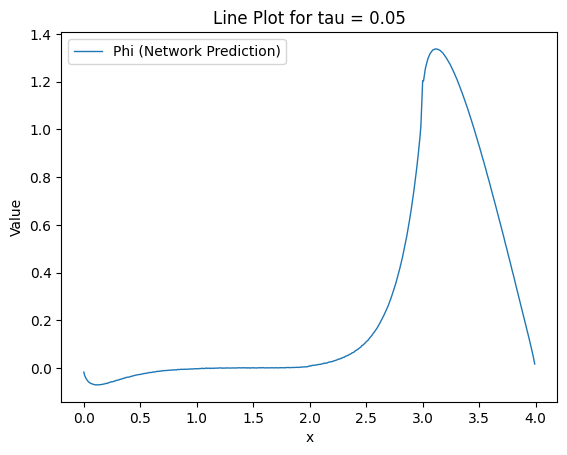

In [50]:
example_g = U(0.05, x_bd_pt).view(1, -1)
Phi_pt = net(0.05, example_g)
Phi_np = Phi_pt.squeeze().cpu().detach().numpy()
plt.plot(np.linspace(0, 4, len(s_for_integral), endpoint=False), Phi_np, linewidth = 1, label="Phi (Network Prediction)")
plt.xlabel("x")
plt.ylabel("Value")
plt.title("Line Plot for tau = 0.05")
plt.legend()
plt.show()

In [51]:
def compare(tau, net):
    g = U(tau, x_bd_pt).view(1, -1)
    
    u_int_pre = predict_u_int(net, tau, g)
    u_int_exact = U(tau, x_interior_pt).view(1, -1) 

    u_bd_pre = predict_u_bd(net, tau, g)
    u_bd_exact = U(tau, x_bd_pt).view(1, -1)

    print("tau = ", tau)
    print("In the domain: ")
    compute_errors(u_int_pre, u_int_exact)

    print("On the boundary:")
    compute_errors(u_bd_pre, u_bd_exact)

In [52]:
def plot(tau, net):
    x_all = np.concatenate([x_interior, x_bd], axis=0)
    print(x_all.shape)

    g = U(tau, x_bd_pt).view(1, -1)
    
    u_int_pre = predict_u_int(net, tau, g)
    u_int_exact = U(tau, x_interior_pt).view(1, -1) 

    u_bd_pre = predict_u_bd(net, tau, g)
    u_bd_exact = U(tau, x_bd_pt).view(1, -1)

    u_exact = np.concatenate([u_int_exact.cpu().detach().numpy(), u_bd_exact.cpu().detach().numpy()], axis=1).T
    print(u_exact.shape)

    u_pre = np.concatenate([u_int_pre.cpu().detach().numpy(), u_bd_pre.cpu().detach().numpy()], axis = 1).T
    print(u_pre.shape)
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6), constrained_layout=True)
    
    sc = axs[0].scatter(x_all[:, 0], x_all[:, 1], c=u_exact, cmap='viridis', marker='o', s=20)
    axs[0].set_xlabel("X coordinate")
    axs[0].set_ylabel("Y coordinate")
    axs[0].set_title(f"Exact solution")
    axs[0].set_aspect('equal')
    fig.colorbar(sc, ax=axs[0], orientation='vertical', label="U values")

    sc = axs[1].scatter(x_all[:, 0], x_all[:, 1], c=u_pre, cmap='viridis', marker='o', s=20)
    axs[1].set_xlabel("X coordinate")
    axs[1].set_ylabel("Y coordinate")
    axs[1].set_title(f"Numerical solution")
    axs[1].set_aspect('equal')
    fig.colorbar(sc, ax=axs[1], orientation='vertical', label="U values")

    sc = axs[2].scatter(x_all[:, 0], x_all[:, 1], c=u_exact - u_pre, cmap='viridis', marker='o', s=20)
    axs[2].set_xlabel("X coordinate")
    axs[2].set_ylabel("Y coordinate")
    axs[2].set_title(f"Error")
    axs[2].set_aspect('equal')
    fig.colorbar(sc, ax=axs[2], orientation='vertical', label="Error values")

    plt.show()

    compute_errors(torch.from_numpy(u_pre), torch.from_numpy(u_exact))

tau =  0.05
In the domain: 
L_inf absolute error: 0.0006044507026672363 || L_2 absolute error: 0.0001777269208105281
L_inf relative error: 0.0009344536811113358 || L_2 relative error: 0.0011204126058146358
On the boundary:
L_inf absolute error: 0.001408696174621582 || L_2 absolute error: 0.0004501517105381936
L_inf relative error: 0.0016783098690211773 || L_2 relative error: 0.001521933008916676
(768, 2)
(768, 1)
(768, 1)


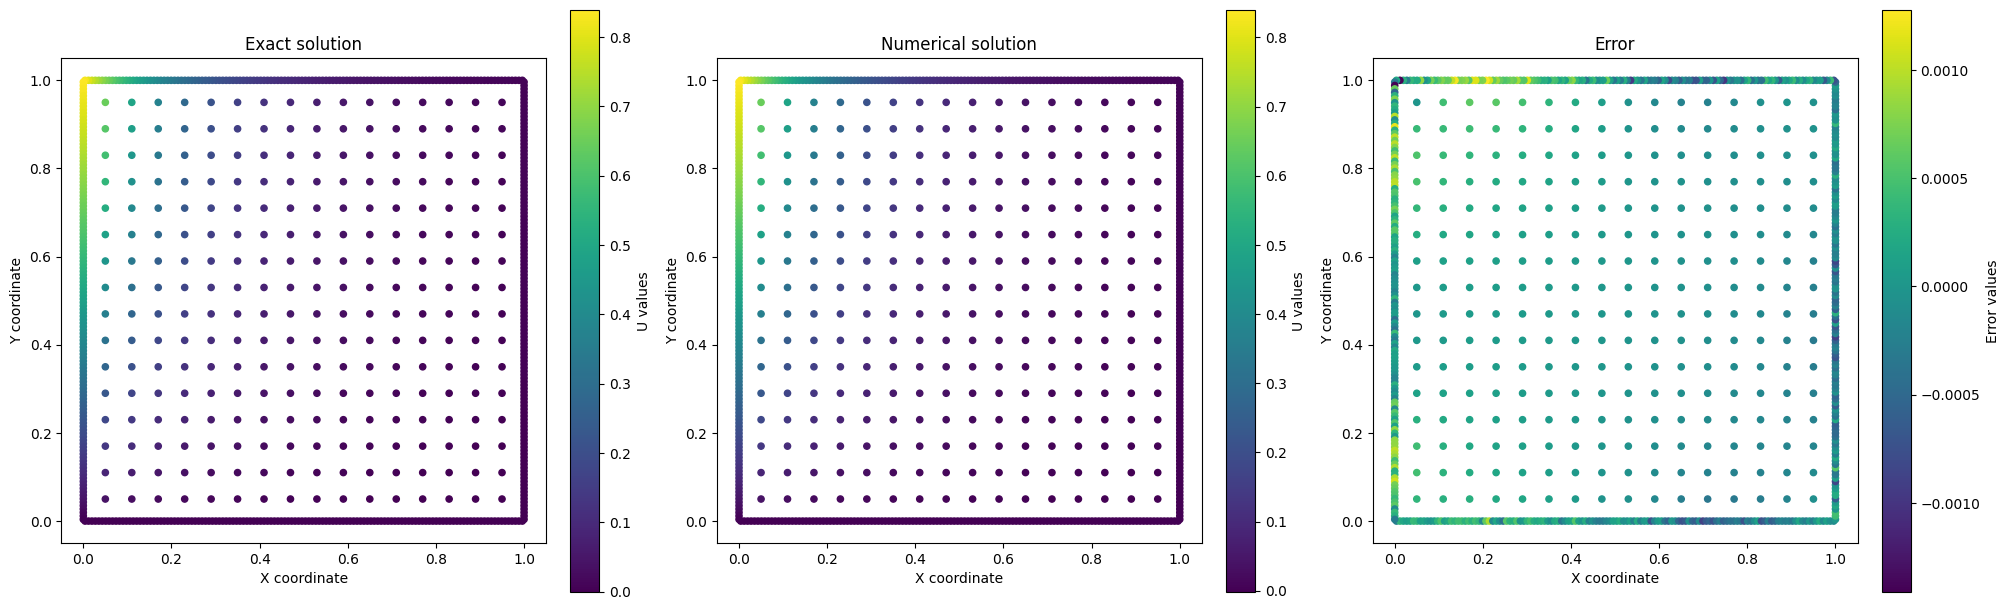

L_inf absolute error: 0.001408696174621582 || L_2 absolute error: 0.00038160185795277357
L_inf relative error: 0.0016783098690211773 || L_2 relative error: 0.0014774593291804194


In [53]:
compare(0.05, net)
plot(0.05, net)  

tau =  0.067
In the domain: 
L_inf absolute error: 0.0006456971168518066 || L_2 absolute error: 0.00011121304123662412
L_inf relative error: 0.000969108659774065 || L_2 relative error: 0.00064568076049909
On the boundary:
L_inf absolute error: 0.0009403824806213379 || L_2 absolute error: 0.00023286962823476642
L_inf relative error: 0.0011203645262867212 || L_2 relative error: 0.0007746862829662859
(768, 2)
(768, 1)
(768, 1)


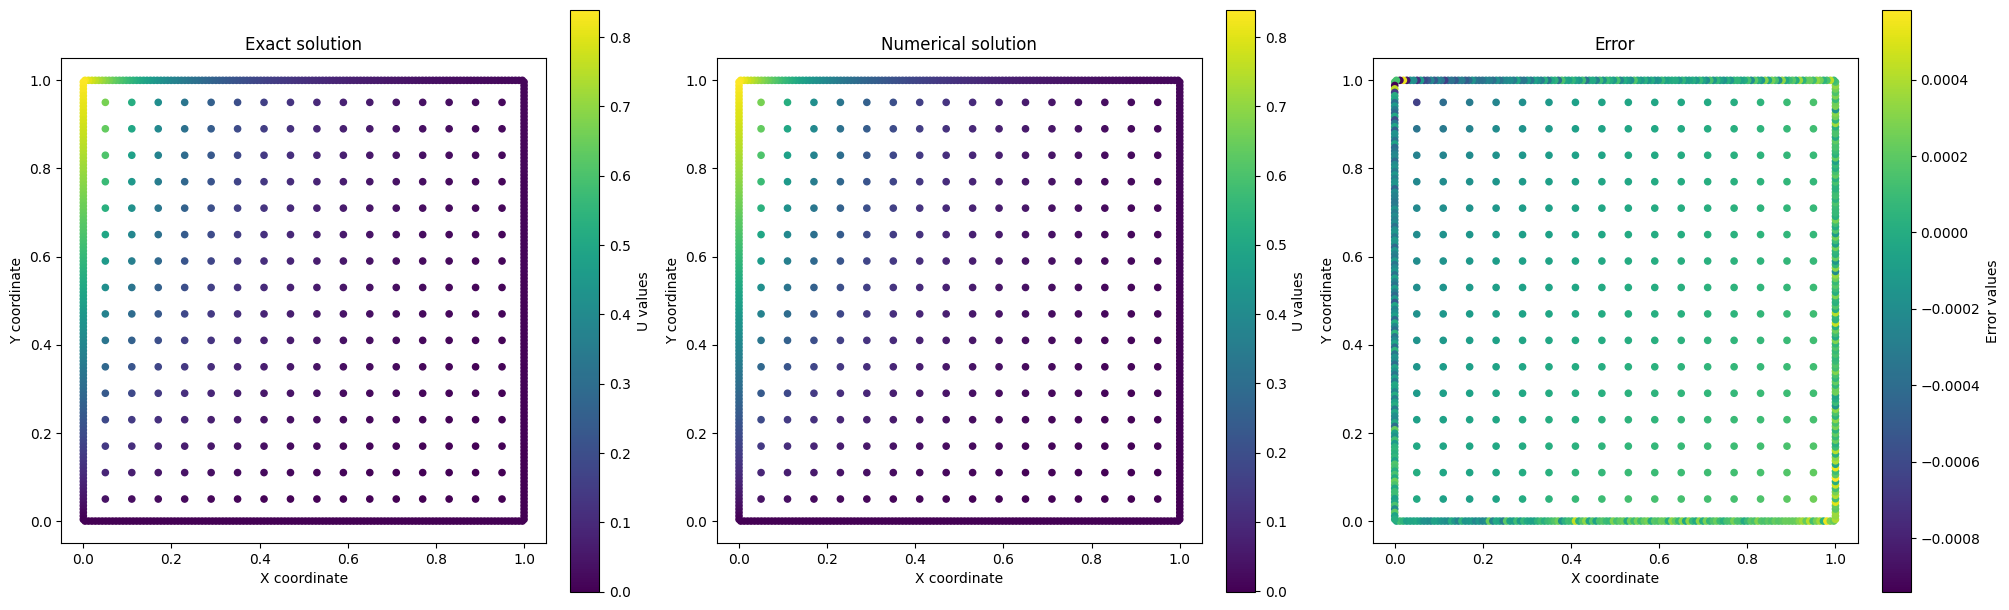

L_inf absolute error: 0.0009403824806213379 || L_2 absolute error: 0.00020068623416591436
L_inf relative error: 0.0011203645262867212 || L_2 relative error: 0.0007578260847367346


In [54]:
compare(0.067, net)
plot(0.067, net)  

tau =  0.1
In the domain: 
L_inf absolute error: 0.0005505729932337999 || L_2 absolute error: 0.0001495460164733231
L_inf relative error: 0.0007989545119926333 || L_2 relative error: 0.0007802598411217332
On the boundary:
L_inf absolute error: 0.001325098448432982 || L_2 absolute error: 0.0003796722157858312
L_inf relative error: 0.0015787121374160051 || L_2 relative error: 0.0012324262643232942
(768, 2)
(768, 1)
(768, 1)


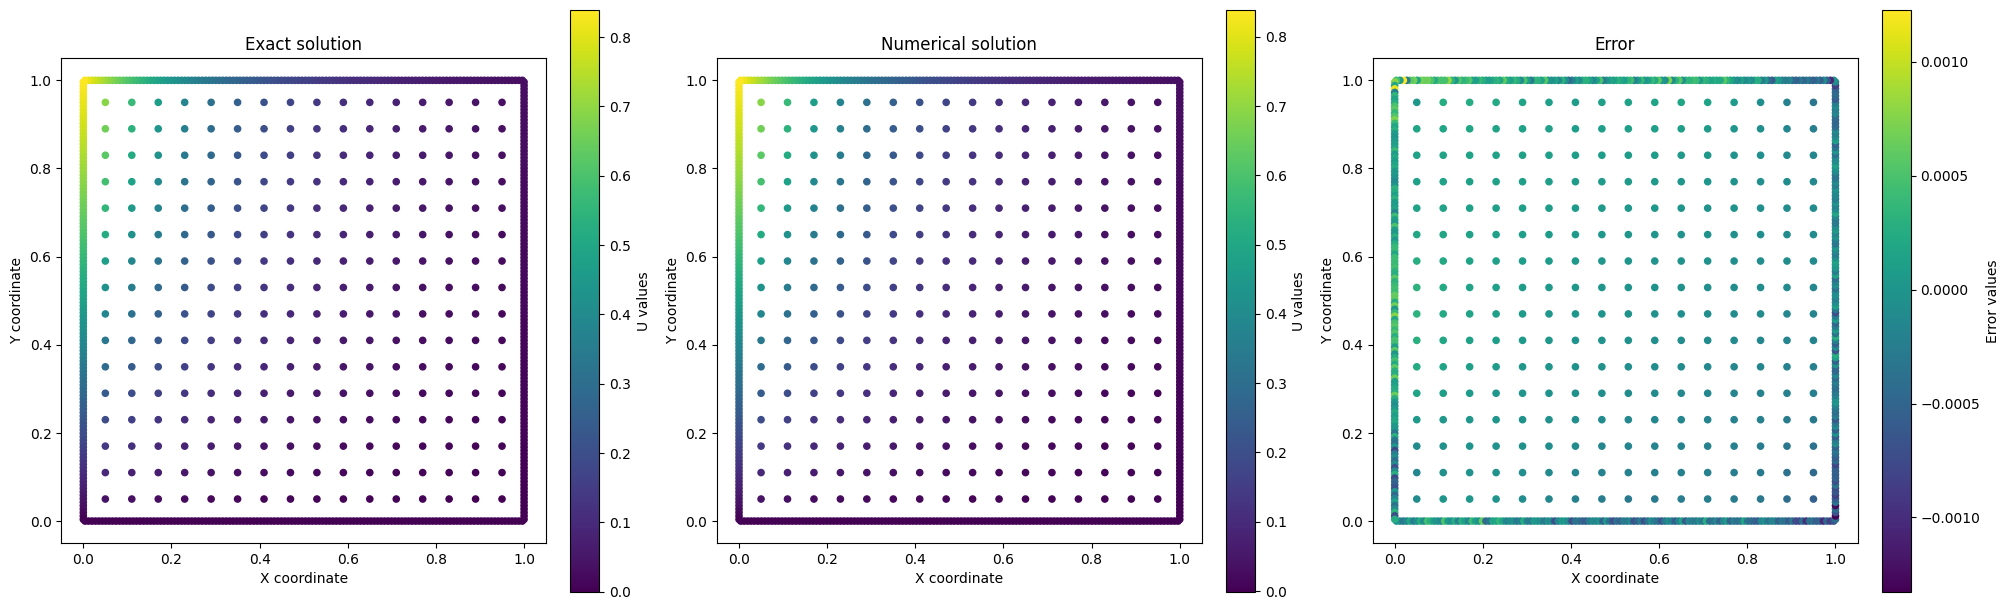

L_inf absolute error: 0.001325098448432982 || L_2 absolute error: 0.0003218001511413604
L_inf relative error: 0.0015787121374160051 || L_2 relative error: 0.001171028707176447


In [55]:
compare(0.1, net)
plot(0.1, net)  